# Publishing Figures - Multi Kappa
This notebook is for generating extratropic specific plots, combining all $\kappa$ simulations.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import clausius_clapeyron_factor, sphum_sat, moist_static_energy
from isca_tools.utils.constants import L_v, c_p, g, R
from isca_tools.utils.stats import z_score_from_confidence_interval
from isca_tools.utils import area_weight_mean_lat, area_weighting
from isca_tools.thesis.adiabat_theory import (get_delta_temp_quant_theory, get_delta_mse_mod_anom_theory,
                                              get_delta_temp_quant_z_theory)
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
import os
import numpy_indexed
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-04-15 09:53:35,339 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [71]:
# Load dataset
# var_keep = ['temp', 'sphum', 'height', 'convflag', 'klzbs']
var_keep = ['temp', 'sphum', 'height']
exp_dir = 'tau_sweep/aquaplanet/depth=1/'
# exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
exp_names.sort()
# exp_names = exp_names[2:-1]     # get rid of coldest 2 and warmest simulation as don't work well
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
tau_lw = np.asarray(tau_lw)
p_surface = float(ds[0].pfull[-1]) * 100

100%|██████████| 8/8 [00:18<00:00,  2.34s/it]


## Get datasets
Get one dataset for each $\kappa$, combining the desired latitudes: `ds_all`. This combines all or just the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [72]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [73]:
# Compute Global Average Surface Temperature and get near surface temperature data
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2
pressure_ft = 500           # Desired approximate pressure of free troposphere (hPa)

# Chose whether to only consider summer days or consider all days
# season = 'all'
season = 'summer'
# season = 'winter'
if season == 'summer':
    season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    season_months = {'nh': [12, 1, 2], 'sh': [6, 7, 8]}   # JJA for NH and DJF for SH

# Tropics
# region = 'tropics'
# lat_min = 0
# lat_max = 20
# Extratropics
region = 'extratropics'
lat_min = 40
lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# region = 'Global'
# lat_min = 0
# lat_max = 90

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')      # only keep the surface values - get rid of pfull coordinate
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)

        if season == 'summer' or season == 'winter':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(lat_min, lat_max)) 
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-lat_max, -lat_min))  
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)

ind_surf = 0
ind_ft = 1
p_surface = float(ds_all[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds_all[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)

100%|██████████| 8/8 [00:38<00:00,  4.84s/it]


## Near Surface Temperature Quantile
Get variables as a function of near-surface temperature quantile

In [74]:
quantiles_all = np.arange(1, 100)
percentile_label = 'Temperature percentile, $x$'
n_quant_all = len(quantiles_all)
n_lat = len(ds_all[0].lat)
n_pressure = ds_all[0].pfull.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine
lnp_const = R * np.log(p_surface/pressure_ft_actual)/2      # for modified MSE calculation

# Days must have klzb < thresh and convflag > thresh to be considered convecting.
klzb_thresh = 13
convflag_thresh = 1

temp_mean = np.zeros((n_exp, n_pressure, n_lat))         # second index: 0 is surface, 1 is free trop
mse_mod_mean = np.zeros((n_exp, n_lat))
sphum_mean = np.zeros((n_exp, n_lat))
z_mean = np.zeros((n_exp, n_lat))

# as function of temperature quantile
temp_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant_all))
mse_mod_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
sphum_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
z_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
convflag_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
klzbs_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
convfract_quant3 = np.zeros((n_exp, n_lat, n_quant_all))            # record fraction of days convecting
with tqdm(total=n_exp*n_lat*n_quant_all, position=0, leave=True) as pbar:
    for i in range(n_exp):
        temp_mean[i] = ds_all[i].temp.mean(dim='lon_time')
        sphum_mean[i] = ds_all[i].sphum.isel(pfull=ind_surf).mean(dim='lon_time')
        z_mean[i] = ds_all[i].height.isel(pfull=ind_ft).mean(dim='lon_time')
        mse_mod = moist_static_energy(ds_all[i].temp[ind_surf], ds_all[i].sphum[ind_surf], height=0, c_p_const=c_p - lnp_const)
        mse_mod_mean[i] = mse_mod.mean(dim='lon_time')
        if 'convflag' in var_keep:
            is_convecting = np.logical_and(ds_all[i].klzbs<klzb_thresh, ds_all[i].convflag > convflag_thresh)
        for k in range(n_lat):
            for j, quant in enumerate(quantiles_all):
                use_ind = get_quant_ind(ds_all[i].temp.isel(pfull=ind_surf)[k], quant, 0.5, 0.5)
                sphum_quant3[i, k, j] = ds_all[i].sphum.isel(pfull=ind_surf)[k, use_ind].mean()
                z_quant3[i, k, j] = ds_all[i].height.isel(pfull=ind_ft)[k, use_ind].mean()
                mse_mod_quant3[i, k, j] = mse_mod[k, use_ind].mean(dim='lon_time')
                temp_quant3[i, :, k, j] = ds_all[i].temp[:, k, use_ind].mean(dim='lon_time')
                if 'convflag' in var_keep:
                    convflag_quant3[i, k, j] = ds_all[i].convflag[k, use_ind].mean(dim='lon_time')
                    klzbs_quant3[i, k, j] = ds_all[i].klzbs[k, use_ind].mean(dim='lon_time')
                    convfract_quant3[i, k, j] = np.sum(is_convecting[k, use_ind])/is_convecting[k, use_ind].size
                pbar.update(1)

100%|██████████| 14256/14256 [00:58<00:00, 242.52it/s]


In [75]:
def get_gradient(temp_quant, temp_av, ref_ind, confidence = 0.9):
    """
    Gets gradient of temperature of given quantile vs average temperature

    Args:
        temp_quant: [n_exp]
        temp_av: [n_exp]
        ref_ind: int
        confidence: float
            Desired confidence in temperature

    Returns:
        float
            Gradient
        [n_exp]
            Predicted temperature for each experiment
        float
            Confidence value for the gradient, such that there is the desired confidence 
            in ± this value about returned gradient.
    """
    fit_func = lambda x, m: temp_quant[ref_ind] + m*(x-temp_av[ref_ind])     # Straight line through the ref point
    param, pcov = scipy.optimize.curve_fit(fit_func,temp_av, temp_quant)[:2]
    # param_with_error = uncertainties.correlated_values(param, pcov)[0]
    # param_std = param_with_error.std_dev
    param_std = np.sqrt(pcov)
    z_score = z_score_from_confidence_interval(confidence)
    return param, fit_func(temp_av, param), z_score * param_std

In [76]:
# delta_temp_quant_theory[-1] will be all zeros and never used, but helpful to keep this shape
delta_temp_quant_theory = {method: np.zeros((n_exp, n_lat, n_quant_all)) for method in
                           ['wtg', 'z', 'wtg_no_rh', 'z_no_rh', 'old', 'old_no_rh', 'best', 'best_no_rh']}
with tqdm(total=(n_exp-1)*n_lat*(len(delta_temp_quant_theory) - 2), position=0, leave=True) as pbar:
    for i in range(n_exp-1):
        for j in range(n_lat):
            for key in delta_temp_quant_theory:
                if 'old' in key:
                    continue
                if 'best' in key:
                    delta_temp_quant_theory[key][i:i+2, j] = \
                        get_delta_temp_quant_theory(temp_mean[i:i+2, ind_surf, j], temp_quant3[i:i+2, ind_surf, j], sphum_mean[i:i+2, j], 
                                                    sphum_quant3[i:i+2, j], p_surface, pressure_ft_actual, 'squared', 'squared', 
                                                    'none' if 'no_rh' in key else 'full')[0]
                else:
                    if 'z' in key:
                        delta_temp_quant_theory[key][i:i+2, j] = \
                            get_delta_temp_quant_z_theory(temp_mean[i:i+2, ind_surf, j], temp_quant3[i:i+2, ind_surf, j], sphum_mean[i:i+2, j],
                                                          sphum_quant3[i:i+2, j], temp_mean[i:i+2, ind_ft, j], temp_quant3[i:i+2, ind_ft, j],
                                                          z_mean[i:i+2, j], z_quant3[i:i+2, j], p_surface, pressure_ft_actual, 
                                                          'linear', 'none' if 'no_rh' in key else 'approx_anomaly')[0]
                    elif 'wtg' in key:
                        delta_temp_quant_theory[key][i:i+2, j], delta_temp_quant_theory[key.replace('wtg', 'old')][i:i+2, j], _ = \
                            get_delta_temp_quant_theory(temp_mean[i:i+2, ind_surf, j], temp_quant3[i:i+2, ind_surf, j], sphum_mean[i:i+2, j],
                                                        sphum_quant3[i:i+2, j], p_surface, pressure_ft_actual, 'linear', 'linear', 
                                                        'none' if 'no_rh' in key else 'approx_anomaly')
                pbar.update(1)

# theory3 adds the same theoretical delta_temp to theory prediction of previous kappa so errors accumulate
temp_quant_theory3 = {method: temp_quant3.copy() for method in delta_temp_quant_theory}
for method in delta_temp_quant_theory:
    for j in range(n_exp-1):
        temp_quant_theory3[method][1+j] = temp_quant_theory3[method][j] + delta_temp_quant_theory[method][j]

100%|██████████| 756/756 [00:21<00:00, 35.58it/s]


In [77]:
confidence = 0.9        # desired confidence for shading in plots
sf_tau_use = [np.where(tau_lw<=np.inf)[0], np.where(tau_lw<=1)[0], np.where(tau_lw>=1)[0]]
sf_tau_ref = [1, 1, 1]
sf_labels = ['All $\kappa$', f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$', f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$']
n_sf = len(sf_tau_use)
# all temperatures averaged above x=0 - same as temp_av except for no area averaging
scaling_factor = np.zeros((n_sf, n_lat, n_quant_all))
scaling_factor_error = np.zeros((n_sf, n_lat, n_quant_all))

scaling_factor_theory = {method: np.zeros((n_sf, n_lat, n_quant_all)) for method in delta_temp_quant_theory}

sf_av = temp_mean[:, ind_surf]

for i in range(n_sf):
    sf_tau_ref_ind = np.where(tau_lw[sf_tau_use[i]]==sf_tau_ref[i])[0]
    for j in range(n_quant_all):
        # The theory predicts median change but not mean hence I use median rather than mean.
        # This means can get theoretical scale factor rather than using simulated mean.
        # This means x=50 will correspond to y=1 in all plots below.
        # Straight line through the ref point
        for k in range(n_lat):
            scaling_factor[i, k, j], _, scaling_factor_error[i, k, j] = get_gradient(temp_quant3[sf_tau_use[i], ind_surf, k, j],
                                                                                     sf_av[sf_tau_use[i], k], sf_tau_ref_ind,
                                                                                     confidence)
            for method in scaling_factor_theory:
                # Use theory2 version for theoretical scaling factor as errors compounded - makes most sense to me
                scaling_factor_theory[method][i, k, j] = get_gradient(temp_quant_theory3[method][sf_tau_use[i], ind_surf, k, j],
                                                           sf_av[sf_tau_use[i], k],
                                                           sf_tau_ref_ind, confidence)[0]

## Simulated Scaling Factor
Combine simulations to plot the simulated warming of a given percentile as a function of the mean warming.

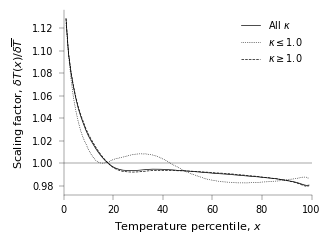

In [78]:
save_sf_fig = False
# if publishing figure, use high dpi
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(quantiles_all, np.average(scaling_factor[0], axis=0, weights=lat_weights), color='k', label=sf_labels[0])
ax.plot(quantiles_all, np.average(scaling_factor[1], axis=0, weights=lat_weights), color='k', linestyle=':',
        label = sf_labels[1])
ax.plot(quantiles_all, np.average(scaling_factor[2], axis=0, weights=lat_weights), color='k', linestyle='--',
        label = sf_labels[2])
ax.hlines(1, 0, 100, lw=ax_linewidth, color='k')
# # Remove some of the lines but keep ylims the same
# ax.lines.pop(1)
# ax.lines.pop(1)
ax.legend()
ax.set_xlim(0,100)
# if quant_type_use == 'x':
#     ax.set_ylim(0.5,1.5)
# else:
#     ax.set_ylim(0.5,2.5)
ax.set_xlabel(percentile_label)
ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
if save_fig or save_sf_fig:
    file_name = f"scaling_factor_multi_kappa_{region.lower()}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf", dpi=dpi['monochrome'] if publish_fig else low_dpi, 
                bbox_inches='tight', pad_inches=save_pad_inches)

### Tropical Theory
Below I apply the theory developed for the tropics to the extratropics. It predicts the amplified warming of cold days, but is not quantitatively accurate.

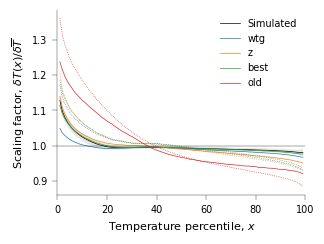

In [79]:
# Do a single plot combining all simulations
sf_ind_use = 0  # 0, 1 or 2
save_sf_theory_fig = True
# if publishing figure, use high dpi
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quantiles_all, np.average(scaling_factor[sf_ind_use], axis=0, weights=lat_weights), color='k', label='Simulated')
for i, key in enumerate(['wtg', 'z', 'best', 'old']):
    ax.plot(quantiles_all, np.average(scaling_factor_theory[key][sf_ind_use], axis=0, weights=lat_weights), color=default_colors[i], 
            label=key)
    ax.plot(quantiles_all, np.average(scaling_factor_theory[key+'_no_rh'][sf_ind_use], axis=0, weights=lat_weights), color=default_colors[i],
            linestyle=':')
# Add error
ax.fill_between(quantiles_all, np.average(scaling_factor[sf_ind_use]-scaling_factor_error[sf_ind_use], axis=0, weights=lat_weights), 
                np.average(scaling_factor[sf_ind_use]+scaling_factor_error[sf_ind_use], axis=0, weights=lat_weights), fc='k', alpha=0.1)
ax.hlines(1, 0, 100, linewidth=ax_linewidth, color='k')
ax.legend()
ax.set_xlim(0,100)
ax.set_xlabel(percentile_label)
ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
if save_fig or save_sf_theory_fig:
    file_name = f"scaling_factor_theory_{region.lower()}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf",dpi=dpi['combination'] if publish_fig else low_dpi, 
                bbox_inches='tight', pad_inches=save_pad_inches)

### $\lambda$ Decomposition
The tropical theory assumes that $\lambda = \delta h(x)/\delta \overline{h} \approx 1$. Below, I split $\lambda$ into three variables linking free troposphere and surface to see why this is no longer the case in the extratropics.

The decomposition shows different things for hot and cold simulations.

In [80]:
# delta_mse_mod_ratio = np.diff(mse_mod_quant3, axis=0)/np.expand_dims(np.diff(mse_mod_mean, axis=0), axis=-1)
delta_mse_mod_anom_theory = {'linear': np.zeros((n_exp-1, n_lat, n_quant_all)), 'squared': np.zeros((n_exp-1, n_lat, n_quant_all))}
for i in range(n_exp-1):
    for j in range(n_lat):
        for key in delta_mse_mod_anom_theory:
            delta_mse_mod_anom_theory[key][i, j] = get_delta_mse_mod_anom_theory(temp_mean[i:i+2, ind_surf, j], temp_quant3[i:i+2, ind_surf, j], 
                                                                           sphum_mean[i:i+2, j], sphum_quant3[i:i+2, j], p_surface, pressure_ft_actual, 
                                                                           taylor_terms=key)[0]
mse_mod_anom = mse_mod_quant3 - mse_mod_mean[:, :, np.newaxis]
# theory3 adds the same theoretical delta_h_anom to theory prediction of previous kappa so errors accumulate
mse_mod_anom_theory3 = {method: mse_mod_anom.copy() for method in delta_mse_mod_anom_theory}
for key in delta_mse_mod_anom_theory:
    for i in range(n_exp-1):
        mse_mod_anom_theory3[key][i+1] = mse_mod_anom_theory3[key][i] + delta_mse_mod_anom_theory[key][i]

In [81]:
mse_mod_anom_sf = np.zeros((n_sf, n_lat, n_quant_all))

mse_mod_anom_sf_theory = {method: np.zeros((n_sf, n_lat, n_quant_all)) for method in delta_mse_mod_anom_theory}

mse_mod_anom_sf_av = mse_mod_mean

for i in range(n_sf):
    sf_tau_ref_ind = np.where(tau_lw[sf_tau_use[i]]==sf_tau_ref[i])[0]
    for j in range(n_quant_all):
        # The theory predicts median change but not mean hence I use median rather than mean.
        # This means can get theoretical scale factor rather than using simulated mean.
        # This means x=50 will correspond to y=1 in all plots below.
        # Straight line through the ref point
        for k in range(n_lat):
            mse_mod_anom_sf[i, k, j] = get_gradient(mse_mod_anom[sf_tau_use[i], k, j], mse_mod_anom_sf_av[sf_tau_use[i], k], sf_tau_ref_ind,
                                                    confidence)[0]
            for key in mse_mod_anom_sf_theory:
                # Use theory2 version for theoretical scaling factor as errors compounded - makes most sense to me
                mse_mod_anom_sf_theory[key][i, k, j] = get_gradient(mse_mod_anom_theory3[key][sf_tau_use[i], k, j],
                                                           mse_mod_anom_sf_av[sf_tau_use[i], k],
                                                           sf_tau_ref_ind, confidence)[0]

In [82]:
# lambda_1 = np.zeros((n_sf, n_lat, n_quant_all))
# lambda_2 = np.zeros((n_sf, n_lat, n_quant_all))
# lambda_3 = np.zeros((n_sf, n_lat))
# lambda_full = np.zeros((n_sf, n_lat, n_quant_all))
# labels = ['$\lambda(x) = \lambda_1(x) \lambda_2(x) / \overline{\lambda_1}$',
#           '$\lambda_1(x)$',
#           '$\lambda_2(x)$',
#           '$\overline{\lambda_1}$']
# 
# 
# with tqdm(total=n_sf*n_lat*n_quant_all, position=0, leave=True) as pbar:
#     for k in range(n_sf):
#         sf_tau_ref_ind = np.where(tau_lw[sf_tau_use[k]]==sf_tau_ref[k])[0]
#         for i in range(n_lat):
#             lambda_3[k, i] = get_gradient(mse_mean[sf_tau_use[k], ind_surf, i], 
#                                           mse_mean[sf_tau_use[k], ind_ft, i], sf_tau_ref_ind)[0]
#             for j in range(n_quant_all):
#                 lambda_1[k, i, j] = get_gradient(mse_quant3[sf_tau_use[k], ind_surf, i, j], 
#                                                  mse_quant3[sf_tau_use[k], ind_ft, i, j], sf_tau_ref_ind)[0]
#                 lambda_2[k, i, j] = get_gradient(mse_quant3[sf_tau_use[k], ind_ft, i, j], 
#                                                  mse_mean[sf_tau_use[k], ind_ft, i], sf_tau_ref_ind)[0]
#                 lambda_full[k, i, j] = get_gradient(mse_quant3[sf_tau_use[k], ind_surf, i, j], 
#                                                     mse_mean[sf_tau_use[k], ind_surf, i], sf_tau_ref_ind)[0]
#                 pbar.update(1)

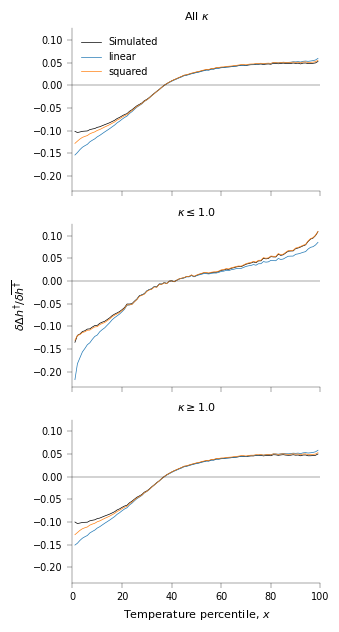

In [83]:
save_lambda_decomp_all_sf_fig = True
fig, ax = plt.subplots(n_sf,1, figsize=(width['one_col'], n_sf*width['one_col']/ar), sharex=True, sharey=True)
for k in range(n_sf):
    ax[k].plot(quantiles_all, np.average(mse_mod_anom_sf[k], axis=0, weights=lat_weights), color='k', label='Simulated')
    for i, key in enumerate(mse_mod_anom_sf_theory):
        ax[k].plot(quantiles_all, np.average(mse_mod_anom_sf_theory[key][k], axis=0, weights=lat_weights), color=default_colors[i], label=key)
    ax[k].axhline(0, color='k', lw=ax_linewidth)
    ax[k].set_title(sf_labels[k])
ax[0].legend()
ax[0].set_xlim(0, 100)
ax[-1].set_xlabel(percentile_label)
ax[1].set_ylabel('$\delta \Delta h^{\dagger} / \delta \overline{h^{\dagger}}$')
# ax.set_xlabel(f"{'Temperature percentile' if quant3_method=='temp' else 'Moist static energy percentile'}, $x$")
# ax.set_ylabel('Ratio of\nmoist static energy changes')
if save_fig or save_lambda_decomp_all_sf_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_anomaly_all_sf_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)